In [1]:
import os
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt

import torchvision
from torchvision import transforms

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, has_labels=True, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.has_labels = has_labels

        if has_labels:
            self.classes = sorted(self.annotations.iloc[:, 1].unique())
            self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        else:
            self.classes = None
            self.class_to_idx = None

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.has_labels:
            label_str = self.annotations.iloc[idx, 1]
            label = self.class_to_idx[label_str]
            return image, label
        else:
            return image, file_name

In [148]:
BATCH_SIZE = 64
dataset_folder = "/home/dahl/Downloads/ContestDataset/"

transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),         
    # transforms.RandomVerticalFlip(p=0.3),         
    # transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

train = CustomDataset(csv_file=dataset_folder + "train.csv", transform=transform, root_dir=dataset_folder + "train/")
test_open = CustomDataset(csv_file=dataset_folder + "test_open.csv", transform=transform, root_dir=dataset_folder + "test_open/")
test = CustomDataset(csv_file=dataset_folder + "test.csv", transform=transform, has_labels=False, root_dir=dataset_folder + "test/")

train_dataloader = DataLoader(train, BATCH_SIZE, shuffle=True)
test_open_dataloader = DataLoader(test_open, BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test, BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the va

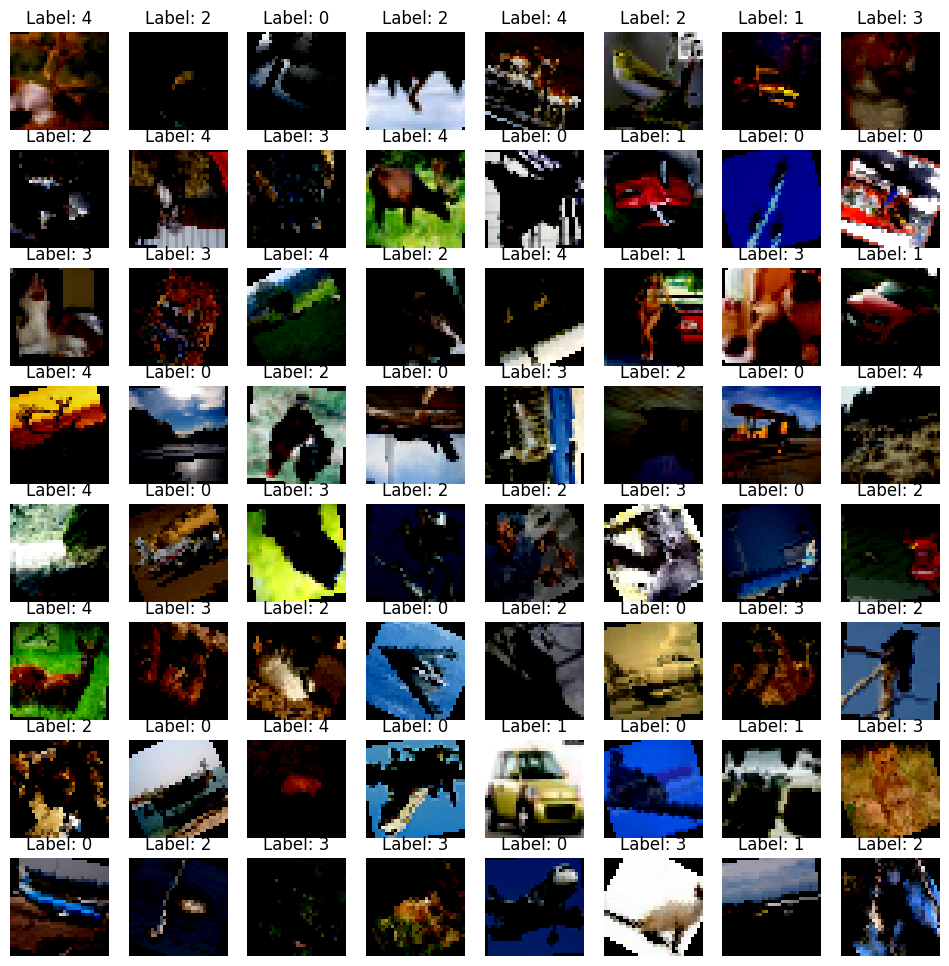

In [82]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# Показываем первую картинку из батча
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(8, 8, i + 1)
    img = image.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(img)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    
plt.show()

In [53]:
class TinyVGG(nn.Module):
    def __init__(self,
                 in_shape: int,
                 hidden_units: int,
                 out_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(hidden_units*8*8,
                     out_shape)
        )

        self.nn = nn.Sequential(
            self.conv_block_1,
            self.conv_block_2,
            self.classifier
        )

    def forward(self, x):
        return self.nn(x)

In [24]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [86]:
torch.manual_seed(42)

model = TinyVGG(
    in_shape=3, 
    hidden_units=64, 
    out_shape=len(train.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=1e-4)

train_loss_list_2, train_acc_list_2, test_loss_list_2, test_acc_list_2 = [], [], [], []

In [90]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
from datetime import datetime

from misc import train_step, test_step, accuracy_fn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

print(device)

start = datetime.now().timestamp()

epochs = 50

for epoch in tqdm(range(epochs)):
    
    train_res = train_step(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optim=optim,
        accuracy_fn=accuracy_fn,
        device=device
    )
    train_loss_list_2.append(train_res["loss"])
    train_acc_list_2.append(train_res["acc"])
    
    test_res = test_step(
        model=model,
        dataloader=test_open_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss_list_2.append(test_res["loss"])
    test_acc_list_2.append(test_res["acc"])
    
    print(f"Epoch: {epoch}, ")
    print(f"train_loss={train_res["loss"]:.3f}, test_loss={test_res["loss"]:.3f}")
    print(f"train_acc={train_res["acc"]:.3f}, test_acc={test_res["acc"]:.3f}")
               
end = datetime.now().timestamp()

print(f"Losted time: {(end - start):.5f}")

cuda


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, 
train_loss=0.785, test_loss=0.888
train_acc=68.750, test_acc=64.688
Epoch: 1, 
train_loss=0.764, test_loss=0.915
train_acc=69.838, test_acc=65.117
Epoch: 2, 
train_loss=0.765, test_loss=0.860
train_acc=69.976, test_acc=66.289
Epoch: 3, 
train_loss=0.775, test_loss=0.949
train_acc=69.343, test_acc=62.734
Epoch: 4, 
train_loss=0.766, test_loss=0.924
train_acc=69.561, test_acc=64.219
Epoch: 5, 
train_loss=0.751, test_loss=0.938
train_acc=70.629, test_acc=63.516
Epoch: 6, 
train_loss=0.769, test_loss=0.989
train_acc=70.075, test_acc=63.750
Epoch: 7, 
train_loss=0.744, test_loss=0.887
train_acc=71.262, test_acc=65.859
Epoch: 8, 
train_loss=0.739, test_loss=0.920
train_acc=71.084, test_acc=65.625
Epoch: 9, 
train_loss=0.746, test_loss=0.934
train_acc=71.341, test_acc=65.469
Epoch: 10, 
train_loss=0.741, test_loss=0.917
train_acc=70.985, test_acc=64.102
Epoch: 11, 
train_loss=0.737, test_loss=0.892
train_acc=70.985, test_acc=65.508
Epoch: 12, 
train_loss=0.723, test_loss=0.971
trai

In [91]:
models = [
    {"name": "v2", "loss": {"train": train_loss_list_2, "test": test_loss_list_2}, "acc": {"train": train_acc_list_2, "test": test_acc_list_2}}
]

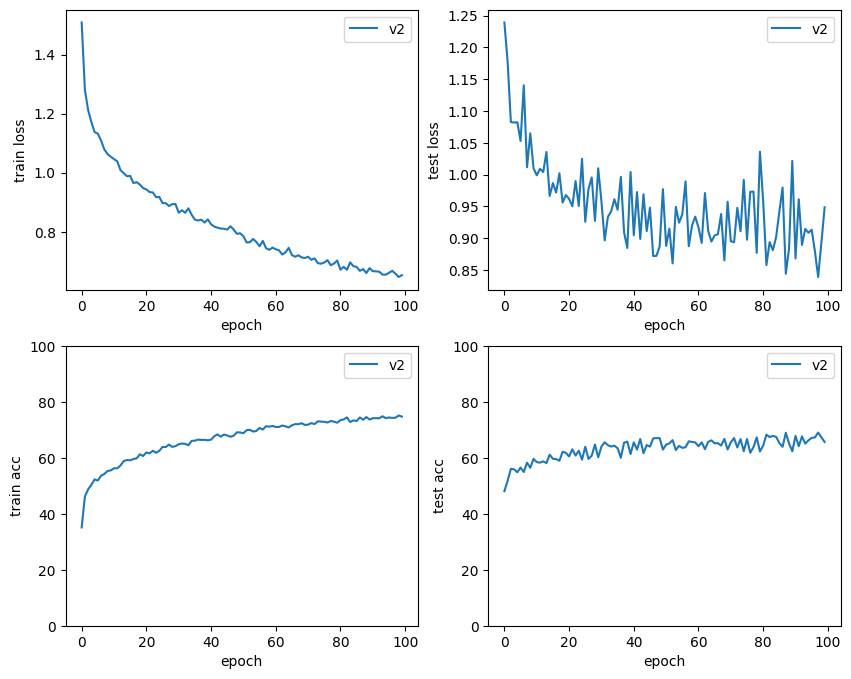

In [92]:
plt.figure(figsize=(10,8))
for model_res in models:
    plt.subplot(2, 2, 1)
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    plt.plot(model_res["loss"]["train"], label=f"{model_res["name"]}")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.plot(model_res["loss"]["test"], label=f"{model_res["name"]}")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.ylim(0, 100)
    plt.xlabel("epoch")
    plt.ylabel("train acc")
    plt.plot(model_res["acc"]["train"], label=f"{model_res["name"]}")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.ylim(0, 100)
    plt.xlabel("epoch")
    plt.ylabel("test acc")
    plt.plot(model_res["acc"]["test"], label=f"{model_res["name"]}")
    plt.legend()


In [93]:
torch.save(model.state_dict(), "v2.pt")

In [149]:
model = TinyVGG(
    in_shape=3, 
    hidden_units=64, 
    out_shape=len(train.classes)
).to(device)

model.load_state_dict(torch.load("v2.pt"))

model.eval()  # отключаем dropout, batchnorm в режим eval
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_open_dataloader:  # если нет меток, _ просто игнорируем
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())  # сохраняем на CPU
        all_labels.extend(labels)

In [150]:
count = 0
for pred, label in zip(all_preds, all_labels):
    if pred == label:
        count += 1

In [151]:
count / len(all_preds)

0.6844

In [152]:
model.eval()
all_preds = []
all_files = []

with torch.no_grad():
    for images, files in test_dataloader:  # если нет меток, _ просто игнорируем
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())  # сохраняем на CPU
        all_files.extend(files)

In [153]:
test_open.classes[all_preds[0]]

'automobile'

In [165]:
def submit(model, dataloader, classes, device):

    df = pd.DataFrame(columns = ('file_name','class'))
    model.eval()
    all_preds = []
    all_files = []
    
    with torch.no_grad():
        for images, files in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_files.extend(files)

    df = pd.DataFrame({
            'file_name': all_files,
            'class': [classes[p] for p in all_preds]
    })
            
    return df

In [166]:
df = submit(model, test_dataloader, test_open.classes, device)

In [167]:
df.head()

,file_name,class
0,cifar10-test-1013.png,automobile
1,cifar10-test-1050.png,airplane
2,cifar10-test-1054.png,automobile
3,cifar10-test-1065.png,bird
4,cifar10-test-1098.png,automobile


In [164]:
df.shape

(2424, 3)

In [168]:
path_submit = 'submit_Mishin_Timofey.csv'

df.to_csv(path_submit, index = False )